In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

%matplotlib inline
%config InlineBackend.figure_format = 'png'


In [2]:
# Data visualisation
dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dftrain_raw.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


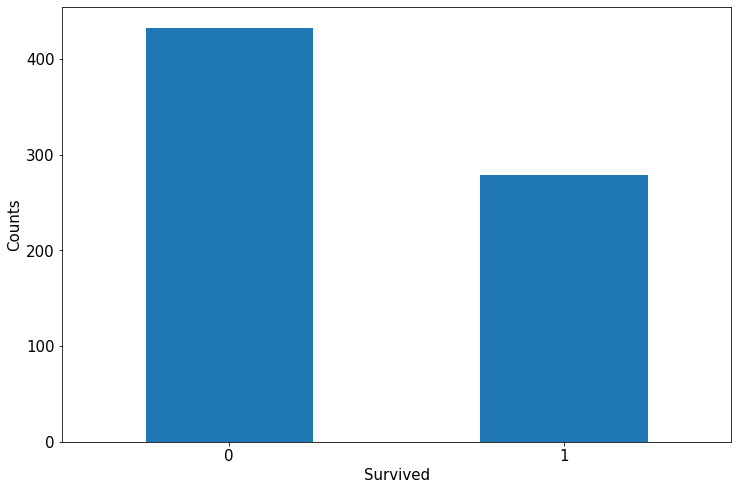

In [3]:
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

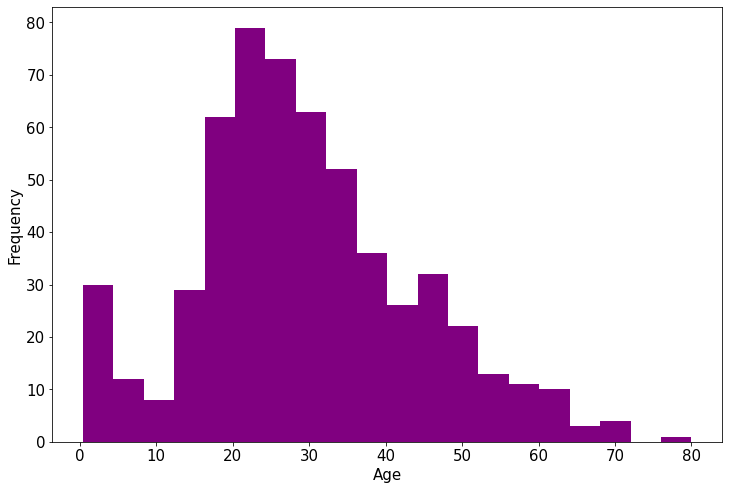

In [4]:
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

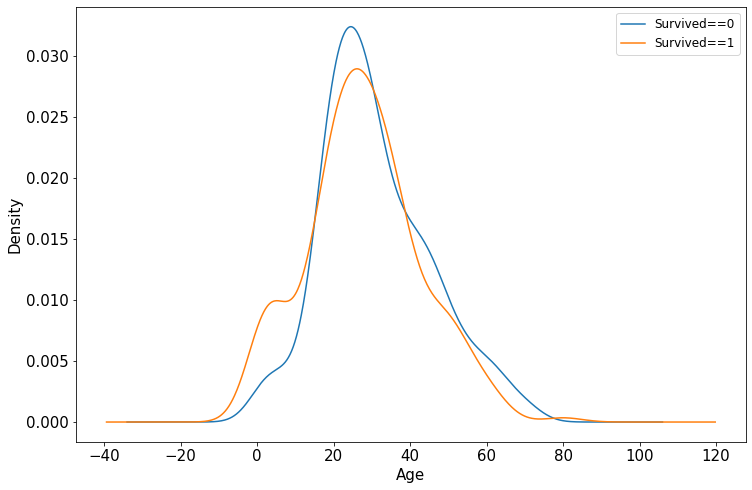

In [5]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [6]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


In [7]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Use binary cross entropy loss function for binary classification
# Note: if argument error here check tensorflow version -> pip list | grep tensorflow and upgrade with pip install --upgrade tensorflow
# REF: loss functions: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #Split part of the training data for validation
                   )

Epoch 1/30
9/9 [==============================] - 0s 28ms/step - loss: 3.2877 - auc: 0.3439 - val_loss: 3.5877 - val_auc: 0.3853
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 2.7924 - auc: 0.3978 - val_loss: 3.1342 - val_auc: 0.3989
Epoch 3/30
9/9 [==============================] - 0s 4ms/step - loss: 2.4372 - auc: 0.4180 - val_loss: 2.7095 - val_auc: 0.4127
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 2.0900 - auc: 0.4350 - val_loss: 2.3454 - val_auc: 0.4248
Epoch 5/30
9/9 [==============================] - 0s 5ms/step - loss: 1.7974 - auc: 0.4617 - val_loss: 2.0306 - val_auc: 0.4402
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 1.5514 - auc: 0.4778 - val_loss: 1.7443 - val_auc: 0.4686
Epoch 7/30
9/9 [==============================] - 0s 4ms/step - loss: 1.3443 - auc: 0.5098 - val_loss: 1.4967 - val_auc: 0.5035
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 1.1571 - auc: 0.5360 - val_loss: 

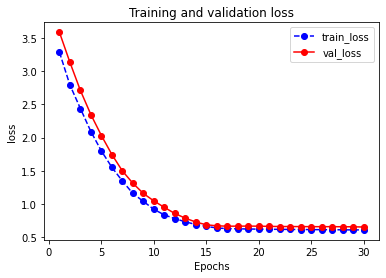

In [10]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


plot_metric(history,"loss")